#**Import Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [2]:
import os
import zipfile
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
dataset_zip = zipfile.ZipFile('/content/drive/MyDrive/FruitDataset.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

# **Dataset Directory Setup**

In [4]:
base_dir = '/content/FruitDataset'
dataset_dir = 'dataset'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

categories = ['fresh', 'rotten']
fruits = ['Apple', 'Banana', 'Grape', 'Guava', 'Mango', 'Orange', 'Strawberry']

for category in categories:
    for fruit in fruits:
        os.makedirs(os.path.join(train_dir, category, fruit), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category, fruit), exist_ok=True)

In [5]:
split_ratio = 0.8
for category in categories:
    for fruit in fruits:
        source_folder = os.path.join(base_dir, category, fruit)
        if not os.path.exists(source_folder):
            continue
        images = os.listdir(source_folder)
        random.shuffle(images)

        train_count = int(len(images) * split_ratio)
        train_images = images[:train_count]
        val_images = images[train_count:]

        for img in train_images:
            shutil.copy(os.path.join(source_folder, img), os.path.join(train_dir, category, fruit, img))

        for img in val_images:
            shutil.copy(os.path.join(source_folder, img), os.path.join(val_dir, category, fruit, img))

## Visualize Distribution of Images per Category and Fruit

Training Dataset Distribution:


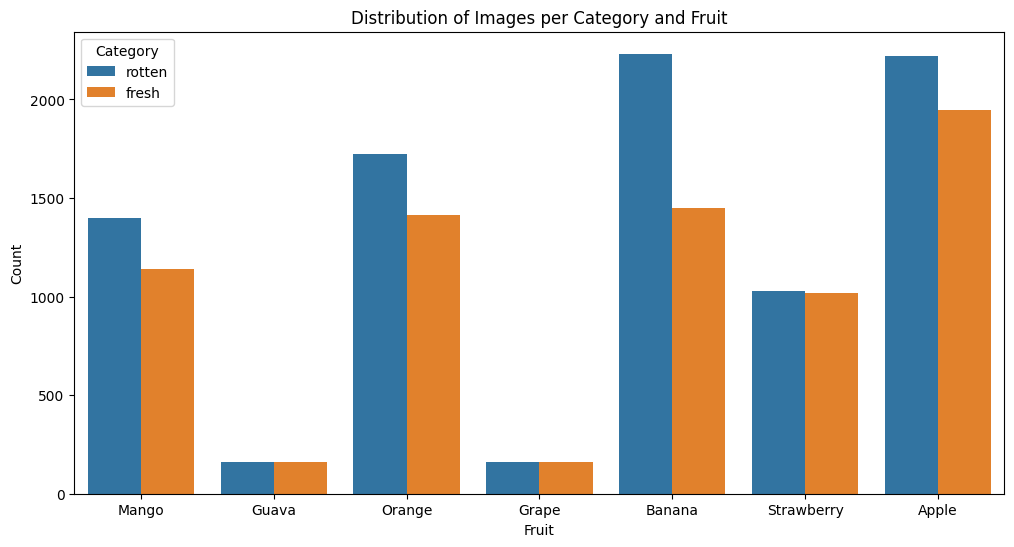


Validation Dataset Distribution:


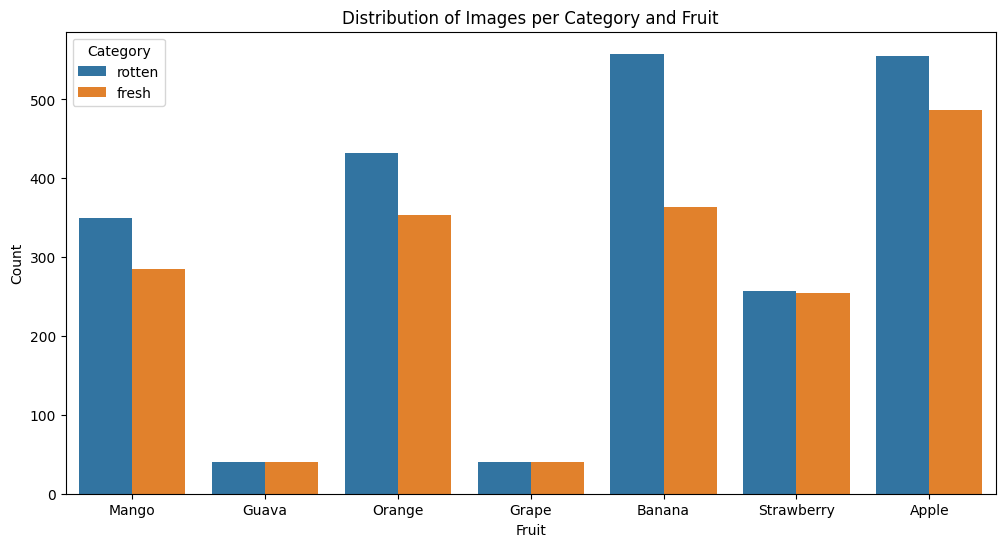

In [7]:
import pandas as pd

def plot_data_distribution(root):
    data = []
    for category in os.listdir(root):
        category_path = os.path.join(root, category)
        if os.path.isdir(category_path):
            for fruit in os.listdir(category_path):
                fruit_folder = os.path.join(category_path, fruit)
                if os.path.isdir(fruit_folder):
                    num_files = len(os.listdir(fruit_folder))
                    data.append({"Category": category, "Fruit": fruit, "Count": num_files})

    df = pd.DataFrame(data)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="Fruit", y="Count", hue="Category")
    plt.title("Distribution of Images per Category and Fruit")
    plt.show()

print("Training Dataset Distribution:")
plot_data_distribution(train_dir)

print("\nValidation Dataset Distribution:")
plot_data_distribution(val_dir)


## Visualize Random Images with Labels

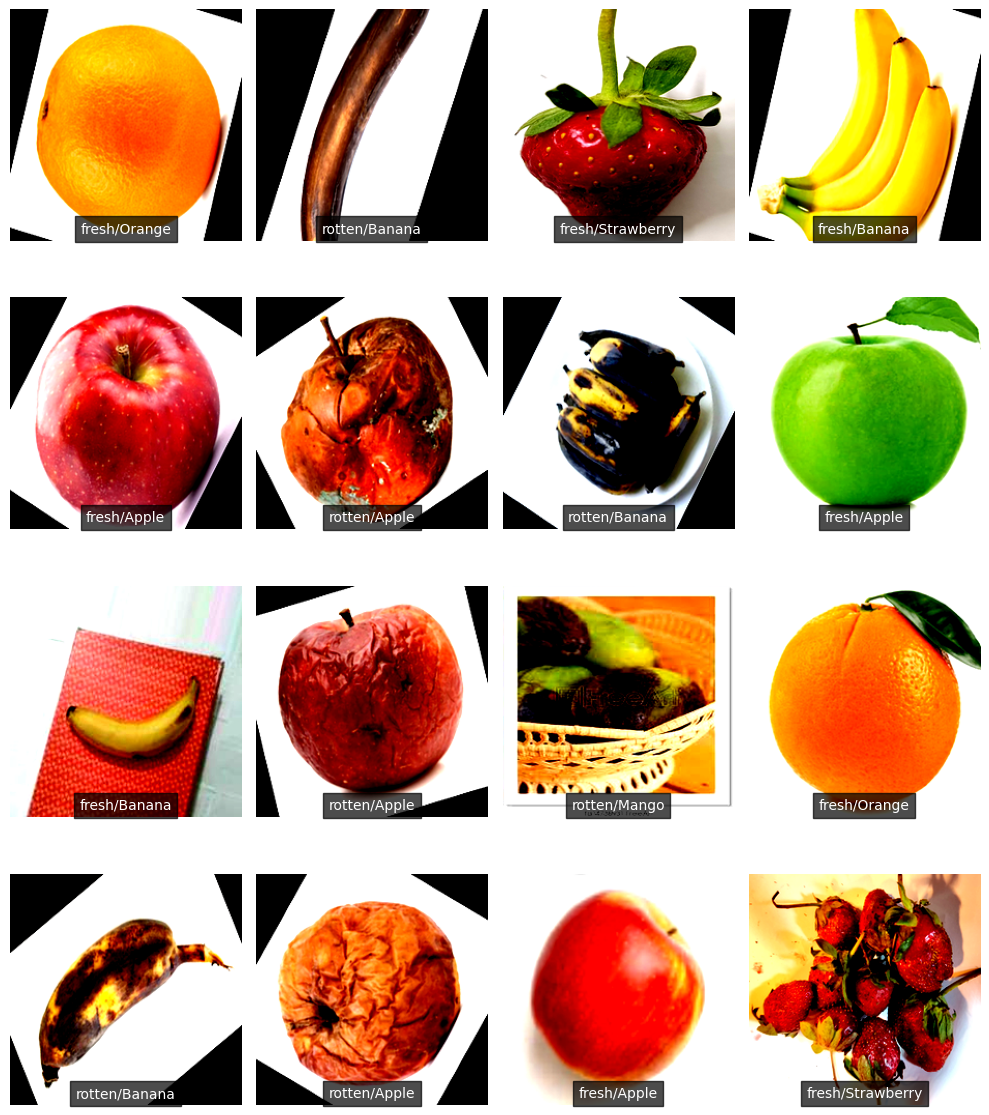

In [8]:
def plot_random_images_with_labels(directories, num_images=16):
    all_images = []

    for directory in directories:
        for subfolder in os.listdir(directory):
            subfolder_path = os.path.join(directory, subfolder)
            if os.path.isdir(subfolder_path):
                for img in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, img)
                    if os.path.isfile(img_path):
                        all_images.append((img_path, f"{os.path.basename(directory)}/{subfolder}"))

    random_images = random.sample(all_images, min(num_images, len(all_images)))

    fig, axes = plt.subplots(4, 4, figsize=(10, 12))
    for ax, (img_path, label) in zip(axes.flatten(), random_images):
        ax.imshow(mpimg.imread(img_path))
        ax.axis('off')
        ax.text(0.5, 0.05, label, ha='center', va='center', transform=ax.transAxes, fontsize=10,
                color='white', bbox=dict(facecolor='black', alpha=0.7))

    plt.tight_layout()
    plt.show()

directories = [
    'dataset/train/fresh',
    'dataset/train/rotten'
]

plot_random_images_with_labels(directories)

# **Augmentation**

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)

Found 16205 images belonging to 2 classes.
Found 4055 images belonging to 2 classes.


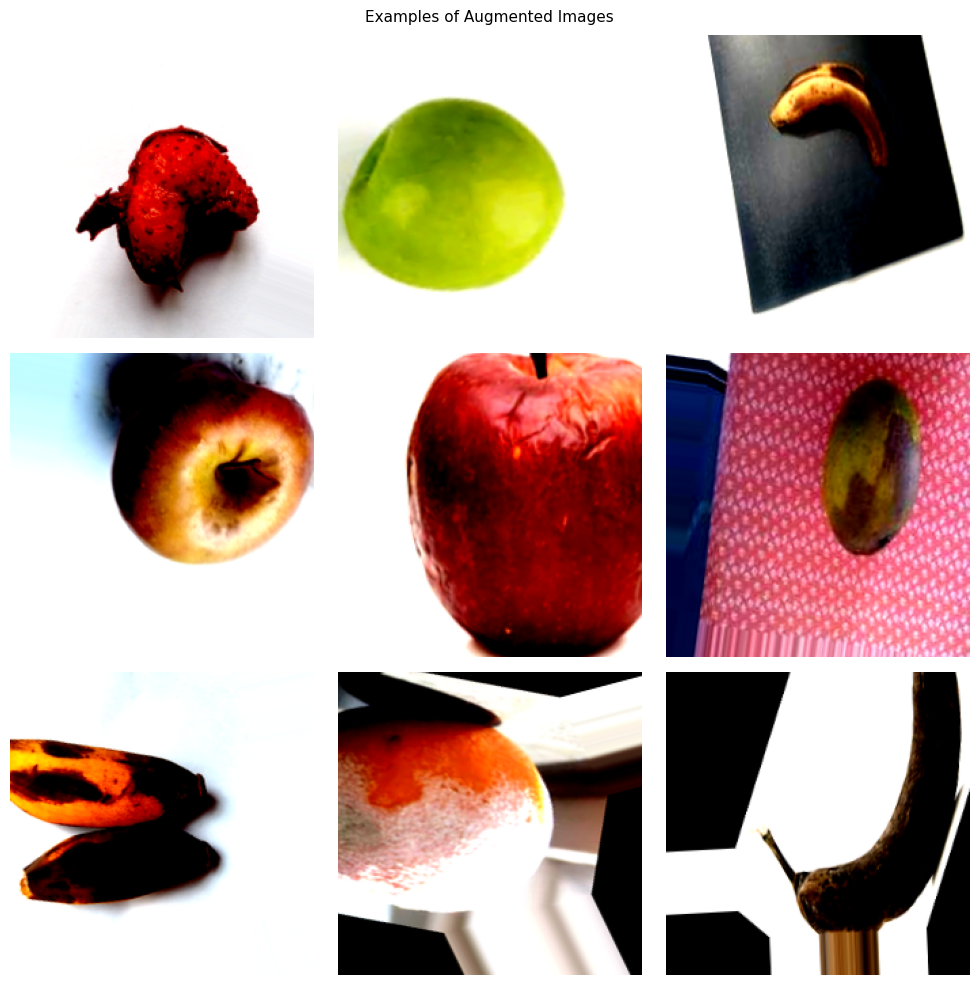

In [18]:
def visualize_augmentations(generator, num_images=9):
    augmented_images, _ = next(generator)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(augmented_images[i])
        ax.axis('off')
    plt.suptitle("Examples of Augmented Images", fontsize=11)
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_generator)

# **Building the Model**

In [19]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

127/127 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.8975 - loss: 0.2588 - val_accuracy: 0.9369 - val_loss: 0.1700
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9179 - loss: 0.2019 - val_accuracy: 0.9512 - val_loss: 0.1316
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9305 - loss: 0.1799 - val_accuracy: 0.9576 - val_loss: 0.1137
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9368 - loss: 0.1581 - val_accuracy: 0.9586 - val_loss: 0.1067
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9423 - loss: 0.1517 - val_accuracy: 0.9652 - val_loss: 0.0935
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9493 - loss: 0.1387 - val_accuracy: 0.9684 - val_loss: 0.0863
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9495 - loss: 0.1308 - val_accuracy: 0.9707 - val_loss: 0.0821
Epoch 9/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9571 - loss: 0.1172 - val_accuracy: 0.971

**Fine-Tuning**

In [23]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [25]:
history_finetune = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9049 - loss: 0.2509 - val_accuracy: 0.8824 - val_loss: 0.3559
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9396 - loss: 0.1506 - val_accuracy: 0.8619 - val_loss: 0.4671
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9568 - loss: 0.1177 - val_accuracy: 0.8792 - val_loss: 0.3899
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9620 - loss: 0.1006 - val_accuracy: 0.8964 - val_loss: 0.3343
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9690 - loss: 0.0853 - val_accuracy: 0.9191 - val_loss: 0.2474
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9682 - loss: 0.0839 - val_accuracy: 0.9332 - val_loss: 0.1928
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9742 - loss: 0.0720 - val_accuracy: 0.9504 - val_loss: 0.1453
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.9769 - loss: 0.0619 - val_accu

## Model evaluation

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step


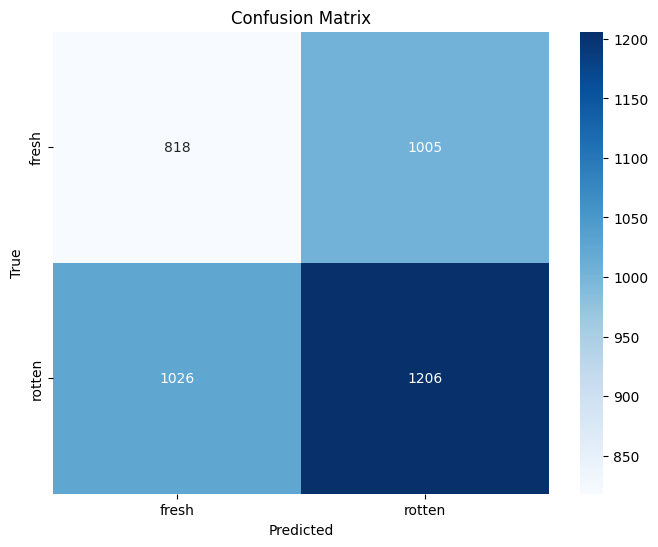

In [35]:
def plot_confusion_matrix(model, generator, class_names):
    y_true = generator.classes
    y_pred = (model.predict(generator) > 0.5).astype(int).flatten()
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

class_names = list(train_generator.class_indices.keys())
plot_confusion_matrix(model, val_generator, class_names)

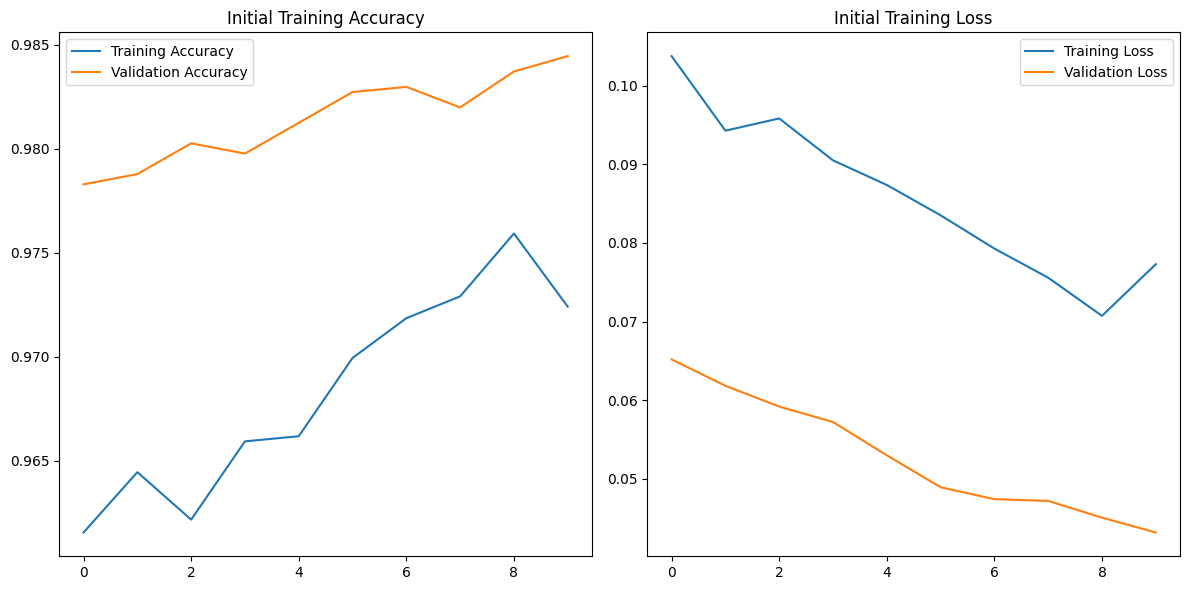

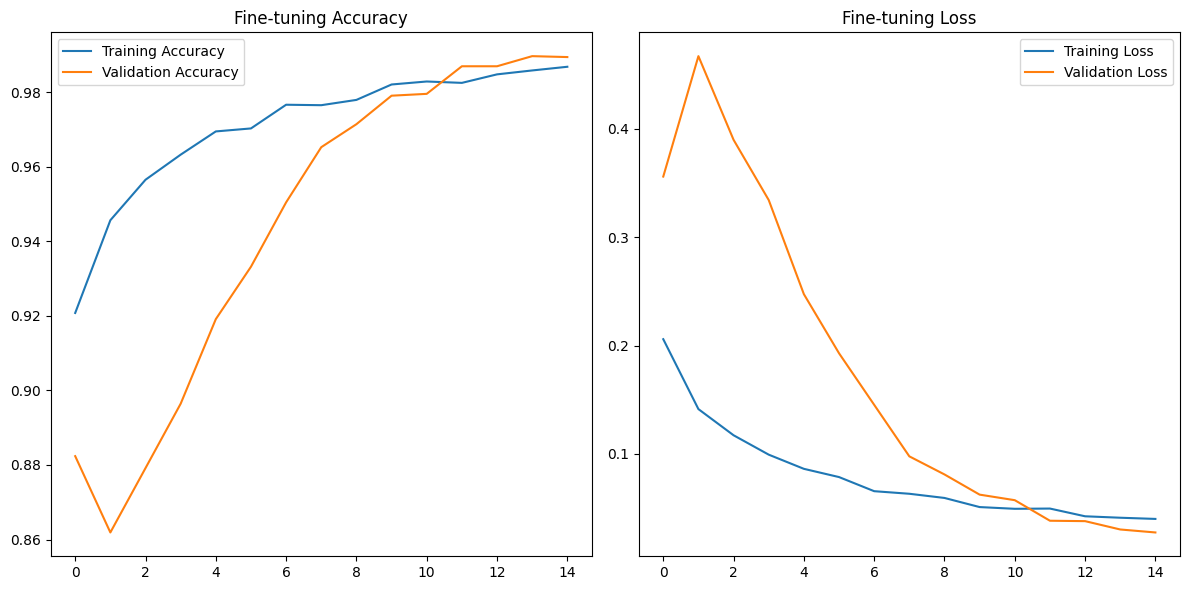

In [28]:
def plot_training_results(history, title="Training and Validation"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f"{title} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f"{title} Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_results(history, title="Initial Training")
plot_training_results(history_finetune, title="Fine-tuning")

In [41]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def test_multiple_images_text_output(model, image_paths, class_indices, target_size=(224, 224)): # Change target_size to (224, 224)
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predicted_class = 'fresh' if prediction[0] < 0.5 else 'rotten'

        print(f"Image: {img_path}")
        print(f"Predicted Class: {predicted_class}")
        print("-" * 40)

image_paths = [
    '/content/rotten1.jfif', '/content/rotten2.jfif', '/content/rotten3.jfif', '/content/rotten4.jfif', '/content/rotten5.jpg',
    '/content/rotten6.jfif', '/content/rotten7.jfif', '/content/rotten8.jfif', '/content/sehat1.jfif', '/content/sehat2.jfif',
    '/content/sehat3.jfif', '/content/sehat4.jfif', '/content/sehat5.jfif', '/content/sehat6.jpg',
    '/content/sehat8.jfif', '/content/sehat8.jpeg', '/content/sehat9.jfif', '/content/sehat10.jfif', '/content/sehat11.jfif',
    '/content/sehat12.jfif', '/content/sehat13.jfif', '/content/sehat14.jfif'
]

test_multiple_images_text_output(model, image_paths, train_generator.class_indices, target_size=(224, 224)) # Change target_size to (224, 224)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: /content/rotten1.jfif
Predicted Class: rotten
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: /content/rotten2.jfif
Predicted Class: rotten
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: /content/rotten3.jfif
Predicted Class: rotten
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: /content/rotten4.jfif
Predicted Class: fresh
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: /content/rotten5.jpg
Predicted Class: rotten
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: /content/rotten6.jfif
Predicted Class: rotten
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: /content/rotten7.jfif
Predicted Class: rotten
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: /content/rotten8.jfif
Predicted C

# **Save Model**

In [43]:
model.save('saved_model.keras')

In [44]:
model.save('model_fruit.h5')